In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
%pip -q install keras-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 863.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [3]:
%pip -q install tensorflow keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [4]:
import tensorflow as tf
import keras
from keras import layers, optimizers

In [5]:
tf.__version__

'2.18.0'

In [6]:
keras.__version__

'3.7.0'

In [7]:
from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary

In [33]:
df = pd.read_csv('SuicideWatch.csv')

In [34]:
df['label'] = df['label'].str.replace('SuicideWatch', 'suicidal')
df['label'] = df['label'].str.lower()

In [35]:
binarized = []
for label in df['label']:
    if label == 'suicidal':
        binarized.append(1)
    else:
        binarized.append(0)

binarized = pd.Series(binarized, name='label')
df = df.drop('label', axis=1)
df = pd.concat([df, binarized], axis=1)

In [36]:
df.head()

,text,label
0,I recently went through a breakup and she said...,0
1,"I do not know how to navigate these feelings, ...",0
2,"So I have been with my bf for 5 months , and h...",0
3,I am so exhausted of this. Just when I think I...,1
4,I have been severly bullied since i was 5 till...,0


In [37]:
df.isna().any().any()

False

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
train_df, other = train_test_split(
    df,
    test_size = 0.9,
    random_state = 9700,
    shuffle = True,
    stratify = df['label'],
)

In [40]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9700,
    shuffle = True,
    stratify = other['label'],
)

In [41]:

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['label'].values)
)

In [42]:
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)

In [43]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [44]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

In [45]:
BITCH_SIZE = 64
auto = tf.data.AUTOTUNE

In [46]:
train_dataset = train_dataset.batch(BITCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BITCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BITCH_SIZE).prefetch(auto)

In [47]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b"i am trying to get into mtg because my partner is into it and i want to do things that they like, but the game makes me so sad for some reason. like i bought a bulk box and i just got a bunch of common boring cards and i cannot stop crying over it?? i wanted really cool cards like my partner has and it is just all junky cards and i feel so let down.this caused a fight with my partner because i was being extremely negative. we have been having a lot of fights recently that are always caused by my negativity. it just gets really bad at night. i do not know. i am sick of crying and i have a doctor's appointment tomorrow and i might just not go. i feel too shitty to do anything. i have been crying over magic cards on and off all day"
0

b'i live in a semi-tropical area where plants take over everything, but i feel like i have this horticultural curse that reflects on my life in general. i have tried to grow plants for years, even building wooden planters, but then once the plants sprout 

In [48]:
#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

20817


In [49]:
reserved_tokens = ["[PAD]", "[UNK]"]

In [50]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [51]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [52]:
print(f'Tokens: {vocab[36:54]}')

Tokens: ['_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']


In [53]:
train_df['text'].apply(lambda x: len(x.split(" "))).describe()

,text
count,2036.000000
mean,164.407171
std,181.896090
min,1.000000
25%,53.000000
50%,107.000000
75%,210.250000
max,2364.000000


In [54]:
MAX_SEQLEN = 256

In [55]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [56]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b"i am trying to get into mtg because my partner is into it and i want to do things that they like, but the game makes me so sad for some reason. like i bought a bulk box and i just got a bunch of common boring cards and i cannot stop crying over it?? i wanted really cool cards like my partner has and it is just all junky cards and i feel so let down.this caused a fight with my partner because i was being extremely negative. we have been having a lot of fights recently that are always caused by my negativity. it just gets really bad at night. i do not know. i am sick of crying and i have a doctor's appointment tomorrow and i might just not go. i feel too shitty to do anything. i have been crying over magic cards on and off all day", shape=(), dtype=string)
Tokens:  tf.Tensor(
[  46   71  208   66  106  214   50  315  501  100   68  704   73  214
   72   67   46   90   66   77  152   78  112   86   13   80   69 1332
  274   76   84  291   82  155  299   15   86   46

In [57]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

In [58]:
def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BITCH_SIZE * 8).prefetch(16).cache()

In [59]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [60]:
from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

In [61]:
EMBED_DIM = 128
INTERMEDIATE_DIM = 512

In [62]:
input_ids = keras.Input(shape=(None,), dtype="int", name="input_ids")

x = TokenAndPositionEmbedding(
    vocabulary_size=vocabulary_size,
    sequence_length=MAX_SEQLEN,
    embedding_dim=EMBED_DIM,
    mask_zero=False,
)(input_ids)

x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)


x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

FentTweaker = keras.Model(input_ids, outputs, name="FentTweaker")

In [63]:
FentTweaker.summary()

Model: "FentTweaker"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 128)           │       2,697,344 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder (FNetEncoder)          │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_1 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_2 (FNetEncoder)        │ (None, None, 128)           │         132,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,094,145 (11.80 MB)

 Trainable params: 3,094,145 (11.80 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
FentTweaker.compile(
    optimizer = optimizers.Adam(learning_rate=1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [66]:
history = FentTweaker.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_ids
Received: inputs=['Tensor(shape=(None, 256))']
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.5229 - loss: 0.7177 - val_accuracy: 0.5031 - val_loss: 0.6900
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6075 - loss: 0.6710 - val_accuracy: 0.5734 - val_loss: 0.6765
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6231 - loss: 0.6543 - val_accuracy: 0.6187 - val_loss: 0.6542
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7238 - loss: 0.5717 - val_accuracy: 0.6173 - val_loss: 0.6678
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7922 - loss: 0.4418 - val_accuracy: 0.6096 - val_loss: 0.7472
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7994 - loss: 0.4059 - val_accuracy: 0.6521 - val_loss: 0.7193
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9406 - loss: 0.1860 - val_accuracy: 0.6147 - val_loss: 0.9664
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9674 - loss: 0.0903 - val_accuracy: 0.6423 - val_loss: 

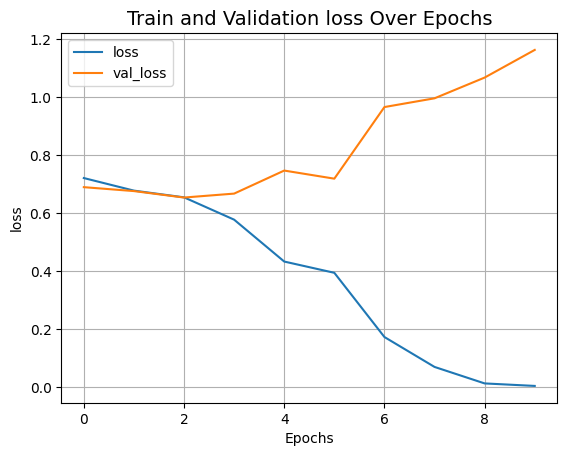

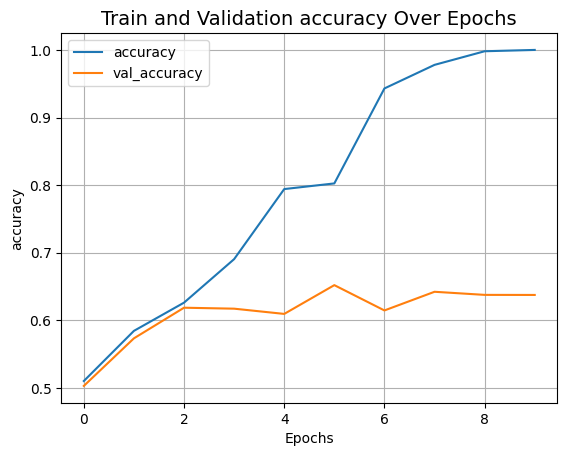

In [68]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [69]:
FentTweaker.evaluate(test_dataset, batch_size=BITCH_SIZE)

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6349 - loss: 1.1496


[1.1215264797210693, 0.6442601680755615]